# Neural Network Classifier 

We are going to build a PyTorch neural network classifier using scRNAseq data. 

Helpful link:
Interfacing pytorch models with anndata: https://anndata.readthedocs.io/en/latest/tutorials/notebooks/annloader.html

Possibly helpful about speeding up pytorch modeling: https://sebastianraschka.com/blog/2023/pytorch-faster.html

This program will:

- pull in scRNAseq data from cell_census
- wrangle the data for modelling
- appply the NN

At first, we're just going to pick some data from cell_census. Once we get the basics we will modify to select the exact data we want.


## To Do:

- train, test, holdout and cross validation
- feature engineering to remove useless features

## Done:
- use softmax for final layer
- use Cross entropy loss
- try ADAM optimizer, adjust learning rate
- plot loss curve
- use RELU for each layer
- plot accuracy curve
- add model.trend() and model.eval()
- add batch summarization 



In [1]:
import cell_census
import anndata as ad

import numpy as np
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='whitegrid')
sns.set_context(context='notebook')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=9,
    linewidth=4
    )

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Read in the data

For now, we're going to select all 10X 3' V3 leukocyte and lymphocyte human data 

- CL:0000738 = leukocyte
- CL:0000542 = lymphocyte


Using ```development-stage``` for the target value because there are 6 unique values, so we have a multi-class classification problem, which will match our eventual goal. This is a place holder until we get a little further in the development of everything.

In [3]:
census = cell_census.open_soma(census_version="latest")


In [4]:
adata = cell_census.get_anndata(
        census=census,
        organism = "Homo sapiens",
        obs_value_filter = '''assay == "10x 3\' v3" and cell_type_ontology_term_id in ["CL:0000738","CL:0000542"]''',
        column_names={"obs": ["development_stage"]},
        )

display(adata)

AnnData object with n_obs × n_vars = 111060 × 60664
    obs: 'development_stage', 'assay', 'cell_type_ontology_term_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

In [5]:
# the data is stored in adata.X
adata.X

<111060x60664 sparse matrix of type '<class 'numpy.float32'>'
	with 139596876 stored elements in Compressed Sparse Row format>

In [6]:
# find the number of features (genes)

adata.X.shape[1]

# returns 2.0
#adata.X[0,40]

60664

## Encode and Split the Data into Train/Validate to prepare for modeling

Encode the label values, then split the data into testing and training sets, then put into PyTorch Tensors.

Using self_reported_ethnicity for the labels

In [7]:
# select the labels. 
labels = adata.obs

In [8]:
labels.head()

,development_stage,assay,cell_type_ontology_term_id
0,62-year-old human stage,10x 3' v3,CL:0000738
1,62-year-old human stage,10x 3' v3,CL:0000738
2,62-year-old human stage,10x 3' v3,CL:0000738
3,62-year-old human stage,10x 3' v3,CL:0000738
4,62-year-old human stage,10x 3' v3,CL:0000738


In [9]:
labels['development_stage'].value_counts()

seventh decade human stage                  23747
sixth decade human stage                    17581
eighth decade human stage                   12497
fifth decade human stage                    10029
fourth decade human stage                    9232
                                            ...  
39-year-old human stage                        34
10th week post-fertilization human stage       27
72-year-old human stage                        18
20th week post-fertilization human stage       13
74-year-old human stage                         7
Name: development_stage, Length: 77, dtype: int64

In [10]:
lb = LabelEncoder()
labels['encoded_labels'] = lb.fit_transform(labels['development_stage'])
labels.head(10)

,development_stage,assay,cell_type_ontology_term_id,encoded_labels
0,62-year-old human stage,10x 3' v3,CL:0000738,40
1,62-year-old human stage,10x 3' v3,CL:0000738,40
2,62-year-old human stage,10x 3' v3,CL:0000738,40
3,62-year-old human stage,10x 3' v3,CL:0000738,40
4,62-year-old human stage,10x 3' v3,CL:0000738,40
5,62-year-old human stage,10x 3' v3,CL:0000738,40
6,62-year-old human stage,10x 3' v3,CL:0000738,40
7,62-year-old human stage,10x 3' v3,CL:0000738,40
8,62-year-old human stage,10x 3' v3,CL:0000738,40
9,62-year-old human stage,10x 3' v3,CL:0000738,40


In [11]:
# find the number of unique labels
labels['encoded_labels'].nunique()

77

In [12]:
y_data = labels['encoded_labels']

In [13]:
x_data = adata.X.copy()

In [14]:
y_data.shape

(111060,)

In [15]:
x_data

<111060x60664 sparse matrix of type '<class 'numpy.float32'>'
	with 139596876 stored elements in Compressed Sparse Row format>

In [16]:
# create training and validation sets here

# using a very small train size to speed up development for now


X_train, X_val, y_train, y_val = train_test_split(x_data,y_data,
                                                   train_size = 0.7)


In [17]:
# convert the data to tensors
# we'll change the data from CSR (compressed sparse row) format
# to COO (coordinate) format for better use with pytorch
# see https://pytorch.org/docs/stable/sparse.html for some details/thoughts



X_train_coo = X_train.tocoo()

X_train = torch.sparse.LongTensor(torch.LongTensor([X_train_coo.row.tolist(),X_train_coo.col.tolist()]),
                                 torch.LongTensor(X_train_coo.data.astype(np.float32)))

# y_train is a Series, so it is easier to convert to a tensor
y_train = torch.tensor(y_train, dtype=torch.long)



# and the same for the test set
X_val_coo = X_val.tocoo()

X_val = torch.sparse.LongTensor(torch.LongTensor([X_val_coo.row.tolist(),X_val_coo.col.tolist()]),
                                 torch.LongTensor(X_val_coo.data.astype(np.float32)))

# y_val is a Series, so it is easier to convert to a tensor
y_val = torch.tensor(y_val, dtype=torch.long)



In [18]:
X_train

tensor(indices=tensor([[    0,     0,     0,  ..., 77741, 77741, 77741],
                       [   25,    29,    39,  ..., 56325, 57766, 57834]]),
       values=tensor([1, 1, 1,  ..., 1, 4, 1]),
       size=(77742, 60611), nnz=97652679, layout=torch.sparse_coo)

In [19]:
y_train

tensor([72, 24, 73,  ..., 72, 72, 72])

## Build Neural Network Classifier

based on https://medium.com/analytics-vidhya/a-simple-neural-network-classifier-using-pytorch-from-scratch-7ebb477422d2

another helpful resource: https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-analysis-train-model

In [20]:
test_size = torch.unique(y_train).size(dim=0)

test_size

77

In [21]:
# number of features (len of X cols)
# select the number of gene columns
input_dim = X_train.size(dim=1) #adata.X.shape[1] 

# number of hidden layers
hidden_layers = 10

# number of classes (unique of y)
output_dim = torch.unique(y_train).size(dim=0) #labels['encoded_labels'].nunique()

In [22]:
print(input_dim,hidden_layers,output_dim)

60611 10 77


In [23]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.linear1 = nn.Linear(input_dim,hidden_layers)
        self.linear2 = nn.Linear(hidden_layers,output_dim)
        self.bn = nn.BatchNorm1d(10)
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.softmax(x,dim=1)
        return x

## Train the Model

In [27]:
# initialize network

clf = Network()

# define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)

epochs = 100
accuracy_vals = []
loss_vals = []

# set the model to training
clf.train()

for epoch in range(epochs):
    running_loss = 0.0

    # set optimizer to zero grad to remove previous epoch gradients
    optimizer.zero_grad()
  
    # forward propagation
    outputs = clf(X_train.float())
    loss = criterion(outputs, y_train)
    
    # backward propagation
    loss.backward()
    
    # optimize
    optimizer.step()
    running_loss += loss.item()
    
    # save accuracy
    _, epoch_pred = outputs.max(dim=1)
    correct = (epoch_pred == y_train).sum().item()
    accuracy_vals.append(correct / len(y_train) * 100.)

    # save loss
    loss_vals.append(loss.item())
    
    # display statistics
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'[{epoch + 1}] loss: {running_loss:.8f} accuracy: {accuracy_vals[-1]:.4f}')


[1] loss: 1.61728120 accuracy: 13.2490
[10] loss: 1.52344155 accuracy: 55.4209
[20] loss: 1.46894157 accuracy: 70.0381
[30] loss: 1.43148994 accuracy: 73.6231
[40] loss: 1.39798081 accuracy: 78.6283
[50] loss: 1.36467600 accuracy: 82.3000
[60] loss: 1.33435214 accuracy: 86.1967
[70] loss: 1.30199873 accuracy: 90.2148
[80] loss: 1.27349961 accuracy: 94.0423
[90] loss: 1.24101067 accuracy: 95.8261
[100] loss: 1.21379137 accuracy: 96.7960


/var/folders/gy/qftxzz157cz4xv36kyp3yp59ztxvbq/T/ipykernel_46767/353249328.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


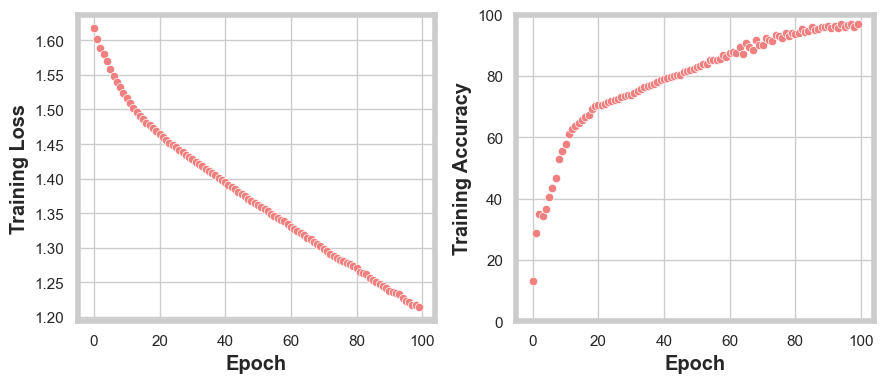

In [28]:
# plot the loss and accuracy curves

fig, ax = plt.subplots(1,2,figsize=(9,4))
sns.scatterplot(x=range(epochs),y=loss_vals, ax = ax[0],color='lightcoral')
sns.scatterplot(x=range(epochs),y=accuracy_vals, ax = ax[1],color='lightcoral')

ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Training Accuracy')
ax[1].set_ylim((0,100))
fig.show()

## Validate the model

Most of this work is based on https://medium.com/analytics-vidhya/a-simple-neural-network-classifier-using-pytorch-from-scratch-7ebb477422d2



In [29]:
clf.eval()

outputs_val = clf(X_val.float())
__, predicted = torch.max(outputs_val,1)
print(predicted)

tensor([4, 2, 4,  ..., 0, 0, 3])


In [30]:
torch.unique(predicted, return_counts=True)

(tensor([0, 1, 2, 3, 4]), tensor([ 7259,  6160, 13600, 12697, 12257]))

In [31]:
clf.eval()

correct, total = 0, 0

with torch.no_grad():
    # calculate output by running through the network
    outputs = clf(X_val.float())
    
    # get the predictions
    __, predicted = torch.max(outputs.data, 1)
    
    # update results
    total += y_val.size(0)
    correct += (predicted == y_val).sum().item()
    
print(f'Accuracy of the network on the test data: {100 * correct // total:.2f} %')

Accuracy of the network on the test data: 88.00 %


## Train and Validate Together

Let's write a function to to the training and validation all at once, so we can compare loss/accuracy curves.

helpful for hyperparameter tuning: https://machinelearningmastery.com/training-and-validation-data-in-pytorch/

In [24]:
def train_and_validate(num_epochs):
    '''
    Performs training and validation simultaneously to allow visualization of model performance 
    per epoch. 
    
    Parameters
    ----------
    num_epochs : int
        integer specify the number of epochs
        
    Returns
    -------
    accuracy_train_hist : list
        list containing accuracy for the training set per epoch
        
    loss_train_hist: list
        list containing loss values for the training set per epoch
        
    accuracy_val_hist : list 
        list containing accuracy for the validation set per epoch
        
    loss_val_hist : list
        list containing loss values for the validation set per epoch
    '''
    # initialize variables for saving values
    accuracy_train_hist = []
    loss_train_hist = []
    accuracy_val_hist = []
    loss_val_hist = []
    best_accuracy = - np.inf
    best_weights = None

    # initialize network
    clf = Network()
    # define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        
        # TRAINING
        #print('Begin Training...')
        clf.train()
        running_train_loss = 0.0
        #running_accuracy = 0.0
        #running_vallidation_loss = 0.0
        #total = 0

        # set optimizer to zero grad to remove previous epoch gradients
        optimizer.zero_grad()

        # forward propagation
        outputs_train = clf(X_train.float())
        loss_train = criterion(outputs_train, y_train)

        # backward propagation
        loss_train.backward()

        # optimize
        optimizer.step()
        running_train_loss += loss_train.item()

        # save accuracy
        _, train_pred = outputs_train.max(dim=1)
        correct_train = (train_pred == y_train).sum().item()
        accuracy_train_hist.append(correct_train / len(y_train) * 100.)

        # save loss
        loss_train_hist.append(loss_train.item())
        
        #print('Begin testing...')
        # TESTING
        
        with torch.no_grad():
            clf.eval()
            # calculate output by running through the network
            outputs_val = clf(X_val.float())

            # get the predictions
            __, predicted_val = outputs_val.max(dim=1)

            # calculate loss
            loss_val = criterion(outputs_val, y_val)

            # save accuracy
            correct_val = (predicted_val == y_val).sum().item()
            accuracy_val_hist.append(correct_val / len(y_val) * 100.)

            # save loss
            loss_val_hist.append(loss_val.item())
            
            # check if best model
            if accuracy_val_hist[-1] > best_accuracy:
                best_acc = accuracy_val_hist[-1]
                best_weights = copy.deepcopy(clf.state_dict())
            
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'[{epoch + 1}] Training Accuracy: {accuracy_train_hist[-1]:.3f} Validation Accuracy: {accuracy_val_hist[-1]:.3f}')

    print(f'Best Accuracy: {best_acc:.3f}')
    #print('Best Weights: ')
    #print(best_weights)
    return(accuracy_train_hist, loss_train_hist, accuracy_val_hist, loss_val_hist)

        

In [27]:
# set the number of epochs and run the model

num_epochs = 51

accuracy_train_hist, loss_train_hist, accuracy_val_hist, loss_val_hist = train_and_validate(num_epochs)

[1] Training Accuracy: 0.126 Validation Accuracy: 2.269
[10] Training Accuracy: 3.734 Validation Accuracy: 7.921
[20] Training Accuracy: 8.241 Validation Accuracy: 10.151
[30] Training Accuracy: 16.119 Validation Accuracy: 13.743
[40] Training Accuracy: 22.513 Validation Accuracy: 16.219
[50] Training Accuracy: 23.471 Validation Accuracy: 23.843
Best Accuracy: 24.080


/var/folders/gy/qftxzz157cz4xv36kyp3yp59ztxvbq/T/ipykernel_90104/488324102.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


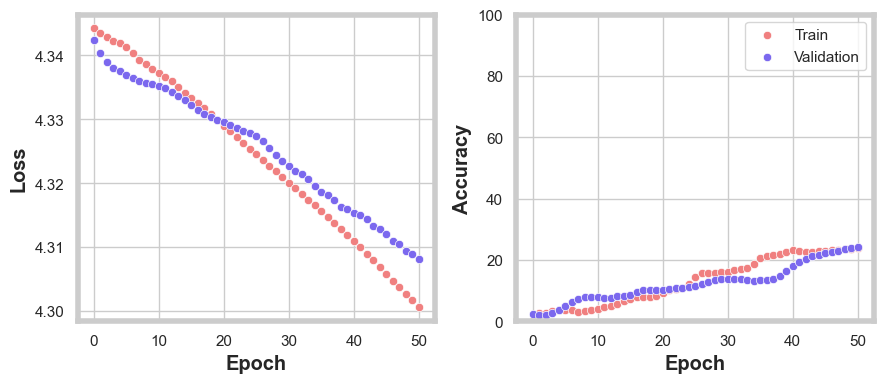

In [28]:


fig, ax = plt.subplots(1,2,figsize=(9,4))
sns.scatterplot(x=range(num_epochs),y=loss_train_hist, ax = ax[0],color='lightcoral')
sns.scatterplot(x=range(num_epochs),y=accuracy_train_hist, ax = ax[1],color='lightcoral',label='Train')

sns.scatterplot(x=range(num_epochs),y=loss_val_hist, ax = ax[0],color='mediumslateblue')
sns.scatterplot(x=range(num_epochs),y=accuracy_val_hist, ax = ax[1],color='mediumslateblue',label='Validation')


ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim((0,100))
fig.show()